## Esteban Gonzalez

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

In [2]:
os.getcwd()

'C:\\Users\\egonz\\OneDrive\\Escritorio\\Desafios\\Unidad 3\\clase6u3'

In [3]:
lista = glob.glob(os.getcwd() + '/dump/*.csv')

In [4]:
lista2=[]
for f in lista:
    lista2.append(pd.read_csv(f, index_col = None, header= 0).drop(columns='Unnamed: 0'))

In [5]:
df = pd.concat(lista2)

In [6]:
df.shape

(9489, 4)

In [7]:
df['1'].value_counts()

rock      4140
hiphop    2535
metal     1582
pop       1232
Name: 1, dtype: int64

In [8]:
df.columns= ['artist','genre', 'song', 'lyric']
df.head()

,artist,genre,song,lyric
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee..."
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...


In [9]:
df['genre'].value_counts()

rock      4140
hiphop    2535
metal     1582
pop       1232
Name: genre, dtype: int64

## 2

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
counter = CountVectorizer(stop_words='english', max_df=.1, max_features=5000)


In [12]:
type(counter)

sklearn.feature_extraction.text.CountVectorizer

In [13]:
counter

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.1, max_features=5000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [14]:
transform_feats = counter.fit_transform(df['lyric'].values)

In [15]:
print(df['lyric'].values)

["Riding hard, high in the saddle \n Winged steed of unwearing flight \n Sweeping through air just like fire \n Swift of the foot, great of might \n Hear the screams \n Feel the bite \n We ride with death \n Tonight \n Here it comes \n You better hide \n Shoot the guns \n You're gonna die \n Conquering all, spreading terror \n Hoofs gallop in thunderous pound \n Devouring the souls of the wretched \n Trampling them down to the ground \n Gripping the reins of destruction \n Made of steel on his hands \n Holder of forces immortal \n Slaughtering all in his path"
 "Racing down the road \n In a street machine of steel \n Gears are jammed in full \n I'm the madman at the wheel \n Got my foot pinned to the floor \n You can feel the engine roar \n I got thunder in my hands \n I'm metal thrashing mad, yeah \n Metal thrashing mad, yeah \n Driving like a maniac \n I can't go any faster \n Burning up the road \n And headed for disaster \n Got my foot pinned to the floor \n You can feel the engine

In [16]:
transform_feats

<9489x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 523193 stored elements in Compressed Sparse Row format>

In [17]:
type(transform_feats)

scipy.sparse.csr.csr_matrix

## 3

In [18]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [19]:
search_params = {'n_components': [5,10,15], 'learning_decay':[0.7, 0.5]}

In [20]:
cv_lda_model = GridSearchCV(LatentDirichletAllocation(learning_method='online'),
                           param_grid=search_params,
                           n_jobs=-1).fit(transform_feats)

C:\Users\egonz\Anaconda3\Anaconda3.2\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [21]:
best_lda= cv_lda_model.best_estimator_

In [22]:
print(cv_lda_model.best_params_)


{'learning_decay': 0.7, 'n_components': 5}


In [23]:
print(cv_lda_model.best_score_)

-2186088.0878030695


In [24]:
print(best_lda.perplexity(transform_feats))

2276.125363368544


## 4

In [25]:
# mediante .components_ podemos extraer una matriz que entrega las distribución de palabras por cada tópico.
for topic_id, topic_name in enumerate(best_lda.components_):
    # para cada tópico
    print("tópico: {}".format(topic_id + 1))
    # mediante argsort logramos ordenar los elementos por magnitud
    # para los elementos más relevantes ordenados por argsort, buscamos su correlativo
    # en la matriz dispersa y devolvemos el nombre.
    # finalmente concatenamos las palabras
    print(" ".join([counter.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))


tópico: 1
ooh ah tonight rock dance whoa roll round friends mama yes talk sing bring girls
tópico: 2
la everybody going ha eat king work white daddy city fucking christmas doo car push
tópico: 3
niggas uh niggaz ma rap fuckin bitches wit gon game da huh bout check word
tópico: 4
believe pain hell forever lost waiting save lonely goodbye fear coming wait born care heaven
tópico: 5
sun na free stand war rain true fight fall sky thought wrong dark change walk


In [26]:
# topico 1 y 2 pop
#topico 3 rock
#topico 4 metal
#topico 5 hiphop

## 5

In [27]:
# generamos una transformación de los datos a distribución de tópico por palabra en el documento
fit_best_lda = best_lda.transform(transform_feats)
# estra transformación la podemos coercionar a un dataframe de la siguiente manera
topics_for_each_doc = pd.DataFrame(
# pasamos esta matriz y la redondeamos en 3 decimales
    np.round(fit_best_lda, 3),
    # agregamos un índice
    index=df.index)

#agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1, best_lda.n_components + 1)))
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df, topics_for_each_doc], axis=1)

In [28]:
fit_best_lda = best_lda.transform(transform_feats)

In [29]:
best_lda

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [30]:
topics = list(map(lambda x: "Topics: {}".format(x), range(1, best_lda.n_components + 1)))

In [31]:
topics

['Topics: 1', 'Topics: 2', 'Topics: 3', 'Topics: 4', 'Topics: 5']

In [32]:
docs_topics = pd.DataFrame(np.round(fit_best_lda, 3), columns= topics, index=df.index)

In [33]:
docs_topics

,Topics: 1,Topics: 2,Topics: 3,Topics: 4,Topics: 5
0,0.082,0.008,0.008,0.894,0.008
1,0.006,0.006,0.205,0.344,0.439
2,0.004,0.004,0.004,0.004,0.985
3,0.493,0.004,0.132,0.367,0.004
4,0.049,0.004,0.004,0.232,0.711
5,0.039,0.005,0.006,0.945,0.006
6,0.737,0.002,0.002,0.257,0.002
7,0.007,0.007,0.007,0.973,0.007
8,0.008,0.008,0.008,0.546,0.430
9,0.004,0.004,0.004,0.459,0.528


In [34]:
concatenate_pr_songs = pd.concat([df, docs_topics], axis=1)

In [35]:
concatenate_pr_songs['highest_topic']= np.argmax(docs_topics.values, axis=1)+1

In [36]:
concatenate_pr_songs

,artist,genre,song,lyric,Topics: 1,Topics: 2,Topics: 3,Topics: 4,Topics: 5,highest_topic
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee...",0.082,0.008,0.008,0.894,0.008,4
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...,0.006,0.006,0.205,0.344,0.439,5
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...,0.004,0.004,0.004,0.004,0.985,5
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...,0.493,0.004,0.132,0.367,0.004,1
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...,0.049,0.004,0.004,0.232,0.711,5
5,Anthrax,metal,Soldiers Of Metal,"We are fighting for your lives \n Ooh, we are ...",0.039,0.005,0.006,0.945,0.006,4
6,Anthrax,metal,Death From Above,Like the screaming eagle \n I'm on the run \n ...,0.737,0.002,0.002,0.257,0.002,1
7,Anthrax,metal,Anthrax,Steel shattered in the night \n Soldiers racin...,0.007,0.007,0.007,0.973,0.007,4
8,Anthrax,metal,Howling Furies,Abandon all hope for those who enter \n Cause ...,0.008,0.008,0.008,0.546,0.430,4
9,Anthrax,metal,A.I.R.,"Young and free, something you'll never be \n A...",0.004,0.004,0.004,0.459,0.528,5


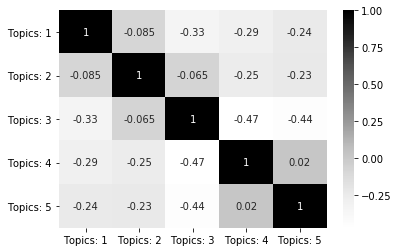

In [37]:
sns.heatmap(concatenate_pr_songs.loc[:,'Topics: 1':'Topics: 5'].corr(), annot = True, cmap = 'Greys')

In [38]:
def fetch_mixture (df, artist):
    return df[df['artist']==artist].loc[:,'Topics: 1':'Topics: 5']

In [39]:
mos_def = fetch_mixture(concatenate_pr_songs, 'Mos Def')

In [40]:
mos_def.columns = ['hardcore_rap', 'rock', 'pop', 'metal', 'bling_era']

In [41]:
mos_def.apply(np.mean, axis=0).sort_values()

rock            0.078231
metal           0.092785
bling_era       0.168277
hardcore_rap    0.187354
pop             0.473392
dtype: float64